In [1]:
%matplotlib ipympl

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
import os
from pathlib import Path

import IPython.display as Ipd

from b2aiprep import process as b2p
import torchaudio

torchvision is not available - cannot save figures


In [4]:
from torchaudio.utils import download_asset

filename1 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
audio1 = b2p.Audio.from_file(filename1)

In [5]:
Ipd.display(Ipd.Audio(data=audio1.signal.squeeze(), rate=audio1.sample_rate))

#### Plot a spectrogram of the signal after resampling to 16KHz

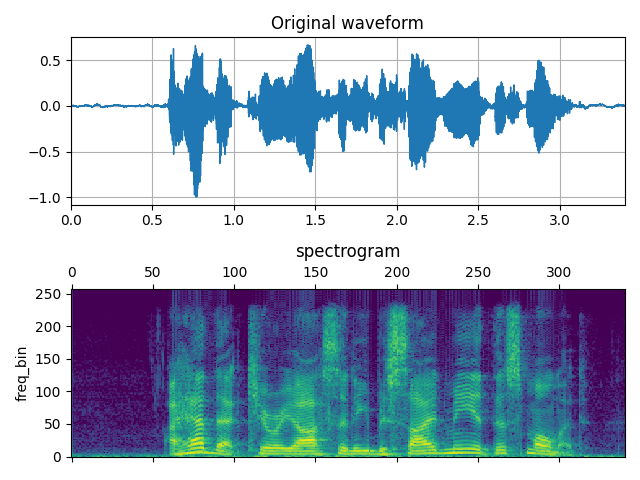

In [6]:
audio1_16 = b2p.resample_iir(audio1, lowcut=7000, new_sample_rate=16000, order=4)
specgram_log = b2p.specgram(audio1_16, toDb=True)
fig, axs = plt.subplots(2, 1)
b2p.plot_waveform(audio1_16.signal,
                  sr=audio1_16.sample_rate,
                  title=f"Original waveform", ax=axs[0])
b2p.plot_spectrogram(specgram_log.T, title="spectrogram", ax=axs[1])
fig.tight_layout()

#### Compute relevant features of the audio and write it out

In [7]:
features, outfile, _ = b2p.to_features(filename1, subject="s1", task="t1",
                                       return_features=True, mpl_backend=None)
outfile

PosixPath('/Users/satra/software/sensein/b2aiprep/docs/sub-s1_task-t1_md5-d226883a847347764b676ec2a26d5fad_features.pt')

#### Plot the spectrogram from the features

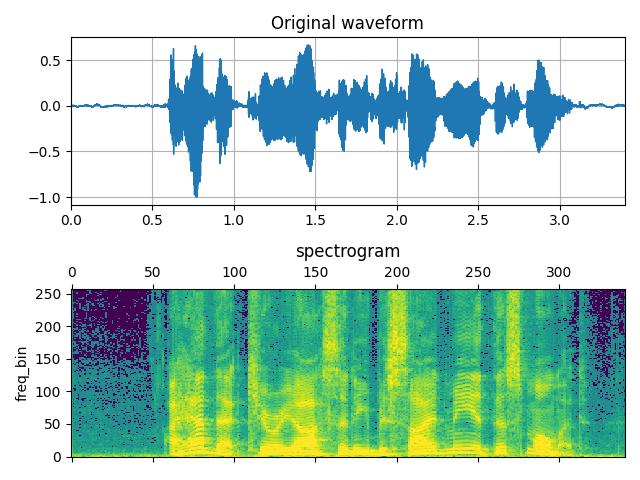

In [8]:
fig, axs = plt.subplots(2, 1)
b2p.plot_waveform(audio1.signal,
                  sr=audio1.sample_rate,
                  title=f"Original waveform", ax=axs[0])
b2p.plot_spectrogram(features['specgram'].T, title="spectrogram", ax=axs[1],
                     norm=LogNorm(vmin=0, vmax=10))
fig.tight_layout()

In [9]:
n_fft = 512
specgram = b2p.specgram(audio1_16, n_fft=n_fft, toDb=False)
win_length = int(audio1_16.sample_rate * 20 / 1000)
hop_length = int(audio1_16.sample_rate * 10 / 1000)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
reconstructed_waveform = griffin_lim(specgram.T) #features['specgram'].T)
Ipd.display(Ipd.Audio(data=reconstructed_waveform, rate=audio1_16.sample_rate))

#### Plot the Mel filterbank

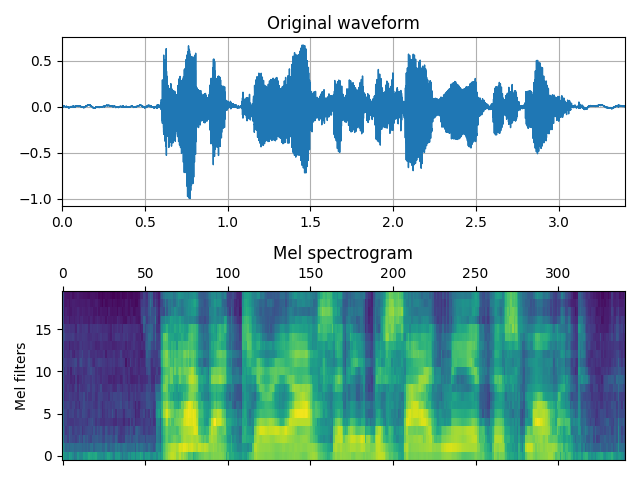

In [10]:
fig, axs = plt.subplots(2, 1)
b2p.plot_waveform(audio1.signal,
                  sr=audio1.sample_rate,
                  title=f"Original waveform", ax=axs[0])
b2p.plot_spectrogram(features['melfilterbank'].T, title="Mel spectrogram",ylabel='Mel filters', ax=axs[1])
fig.tight_layout()

#### Plot the MFCC + delta coefficients

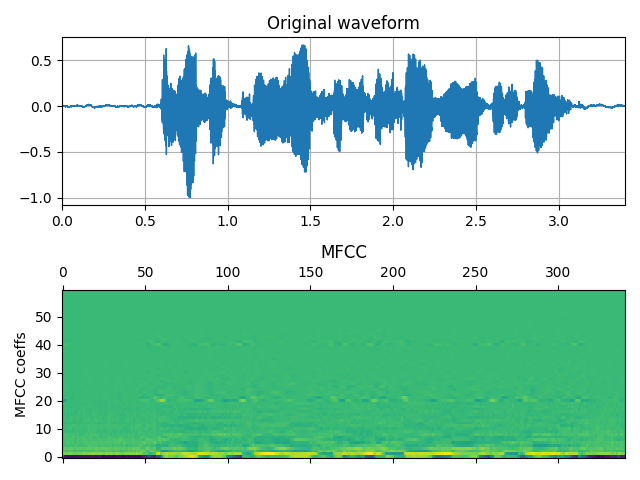

In [11]:
fig, axs = plt.subplots(2, 1)
b2p.plot_waveform(audio1.signal,
                  sr=audio1.sample_rate,
                  title=f"Original waveform", ax=axs[0])
b2p.plot_spectrogram(features['mfcc'].T, title="MFCC", ylabel='MFCC coeffs', ax=axs[1])
fig.tight_layout()

#### Verify if two recordings are from the same speaker

In [12]:
audio_reconstructed = b2p.Audio(signal=reconstructed_waveform, sample_rate=audio1_16.sample_rate)
score, prediction = b2p.verify_speaker(audio1, audio_reconstructed, model='speechbrain/spkrec-ecapa-voxceleb', model_rate=16000)
print(f"Score: {float(score):.2f}, Prediction: {bool(prediction)}")

Score: 0.96, Prediction: True
